In [1]:
import pandas as pd
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import matplotlib as mpl
from sklearn import preprocessing
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

# getting dataset csv file from GitHub
confirmed_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
recovered_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
death_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
confirmed_download = requests.get(confirmed_url).content
recovered_download = requests.get(recovered_url).content
death_download = requests.get(death_url).content

# reading dataset and convert to pandas dataframe
confirmed_df = pd.read_csv(io.StringIO(confirmed_download.decode('utf-8')))
recovered_df = pd.read_csv(io.StringIO(recovered_download.decode('utf-8')))
death_df = pd.read_csv(io.StringIO(death_download.decode('utf-8')))

In [2]:
# calculating sums for all days & Province/States for each country
confirmed = confirmed_df.groupby(['Country/Region']).sum().iloc[:,4:].sum(axis=1)
recovered = recovered_df.groupby(['Country/Region']).sum().iloc[:,4:].sum(axis=1)
death = death_df.groupby(['Country/Region']).sum().iloc[:,4:].sum(axis=1)

# calculating country-wise active cases
active = confirmed - recovered - death

# calculating mortality & recovery rates
mortality_rate = death/confirmed
recovery_rate = recovered/confirmed

# naming the new aggregate columns by converting to frame
confirmed = confirmed.to_frame().rename(columns = {0:'Confirmed'})
recovered = recovered.to_frame().rename(columns = {0:'Recovered'})
death = death.to_frame().rename(columns = {0:'Deaths'})
active = active.to_frame().rename(columns = {0:'Active'})
mortality_rate = mortality_rate.to_frame().rename(columns = {0:'Mortality Rate'})
recovery_rate = recovery_rate.to_frame().rename(columns = {0:'Recovery Rate'})

In [3]:
# combining results into single df
all_df = [confirmed, recovered, death, active, mortality_rate, recovery_rate]
result = reduce(lambda  left,right: pd.merge(left,right,on=['Country/Region'],
                                            how='outer'), all_df).fillna('void')

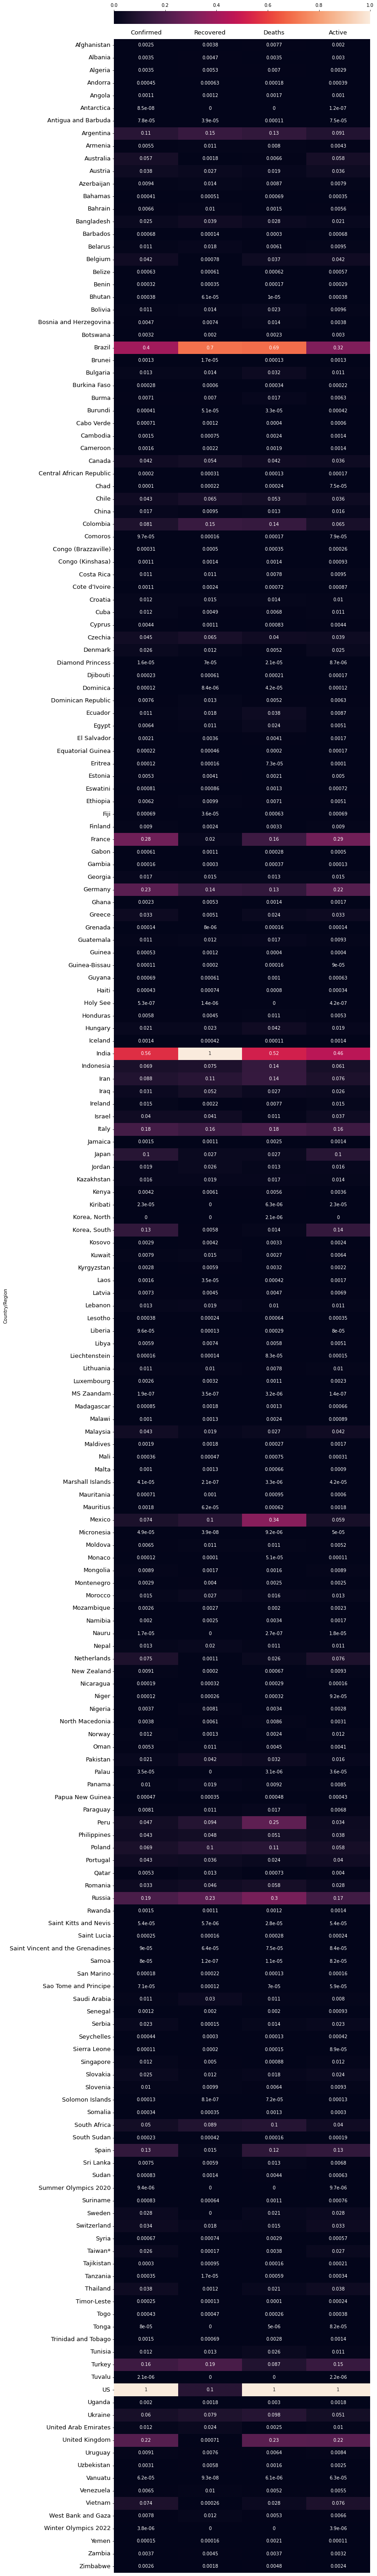

In [4]:
# visualizing total confirmed, recovered, death and active cases

# creating merged df 
values_list = [confirmed, recovered, death, active]
values_df = reduce(lambda  left,right: pd.merge(left,right,on=['Country/Region'],
                                            how='outer'), values_list).fillna('void')
# getting list of countries
countries = values_df.index 

# normalizing data and creating df
values_df = preprocessing.MinMaxScaler().fit_transform(values_df)
values_df = pd.DataFrame(values_df, columns=["Confirmed", "Recovered", "Deaths", "Active"], index=countries)

#plotting the heatmap
plt.figure(figsize=(10,120))
plt.tick_params(axis='both', which='major', labelsize=13, labelbottom = False, bottom=False, top = False, labeltop=True) # axis labels
sns.heatmap(data = values_df, annot = True, annot_kws={'fontsize': 10},
            cbar_kws=dict(use_gridspec=False,location="top",pad=0.005))

# saving the heatmap as png
plt.savefig(r'.\results\Values.png',bbox_inches='tight', dpi=300)

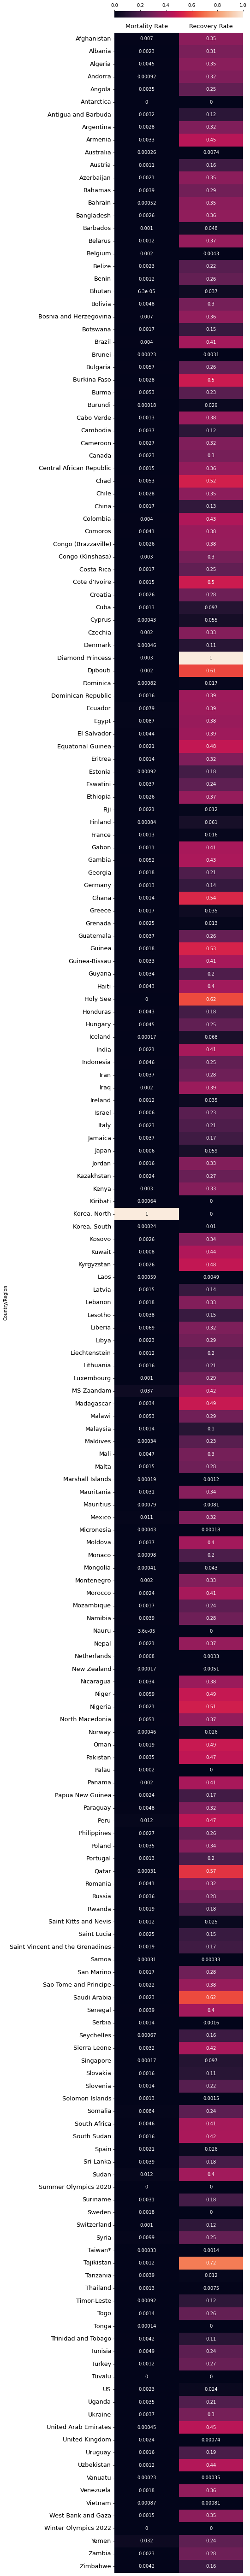

In [5]:
# visualizing mortality rates and recovery rates

# creating merged df 
rates_list = [mortality_rate, recovery_rate]
rates_df = reduce(lambda  left,right: pd.merge(left,right,on=['Country/Region'],
                                            how='outer'), rates_list).fillna('void')
# getting list of countries
countries = rates_df.index

# normalizing data and creating df
rates_df = preprocessing.MinMaxScaler().fit_transform(rates_df)
rates_df = pd.DataFrame(rates_df, columns=['Mortality Rate', 'Recovery Rate'], index=countries)

# plotting heatmap
plt.figure(figsize=(5,120))
plt.tick_params(axis='both', which='major', labelsize=13, labelbottom = False, bottom=False, top = False, labeltop=True) # axis labels
sns.heatmap(data = rates_df, annot = True, annot_kws={'fontsize': 10},
            cbar_kws=dict(use_gridspec=False,location="top",pad=0.005))

# saving heatmap as png
plt.savefig(r'.\results\Rates.png',bbox_inches='tight', dpi=300)

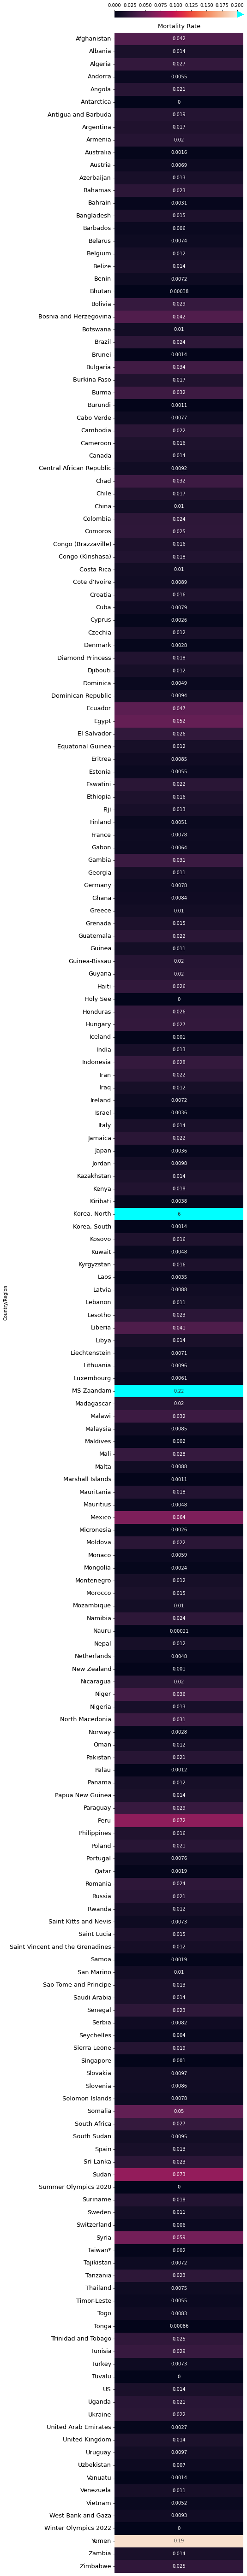

In [6]:
# data for mortality rate was skewed so creating another heatmap
# to show outliers seperate from other data
cmap = mpl.cm.get_cmap("rocket").copy()
cmap.set_over('cyan')
plt.figure(figsize=(5,120))
plt.tick_params(axis='both', which='major', labelsize=13, labelbottom = False, bottom=False, top = False, labeltop=True)
sns.heatmap(data = mortality_rate, annot = True, annot_kws={'fontsize': 10},
            vmin = 0 , vmax = 0.2, cmap=cmap, cbar=True,
            cbar_kws=dict(use_gridspec=False,location="top",pad=0.005, extend='max'))
plt.savefig(r'.\results\MortalityRate.png',bbox_inches='tight', dpi=300)

In [7]:
# finding month-wise confirmed cases

month_confirmed = confirmed_df.copy()

# dropping columns that are not needed
month_confirmed.drop('Lat', inplace=True, axis=1)
month_confirmed.drop('Long', inplace=True, axis=1)

# grouping by months
month_confirmed = month_confirmed.groupby(['Country/Region']).sum().T
month_confirmed.insert(0, 'Month', pd.to_datetime(month_confirmed.index))
month_confirmed["Month"] = pd.to_datetime(month_confirmed["Month"])
month_confirmed['Month'] = month_confirmed['Month'].dt.to_period('M')
month_confirmed = month_confirmed.groupby(['Month']).sum()

C:\Users\Rehan pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Period']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Rehan pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Period']. An error will be raised in 1.2.
  warnings.warn(


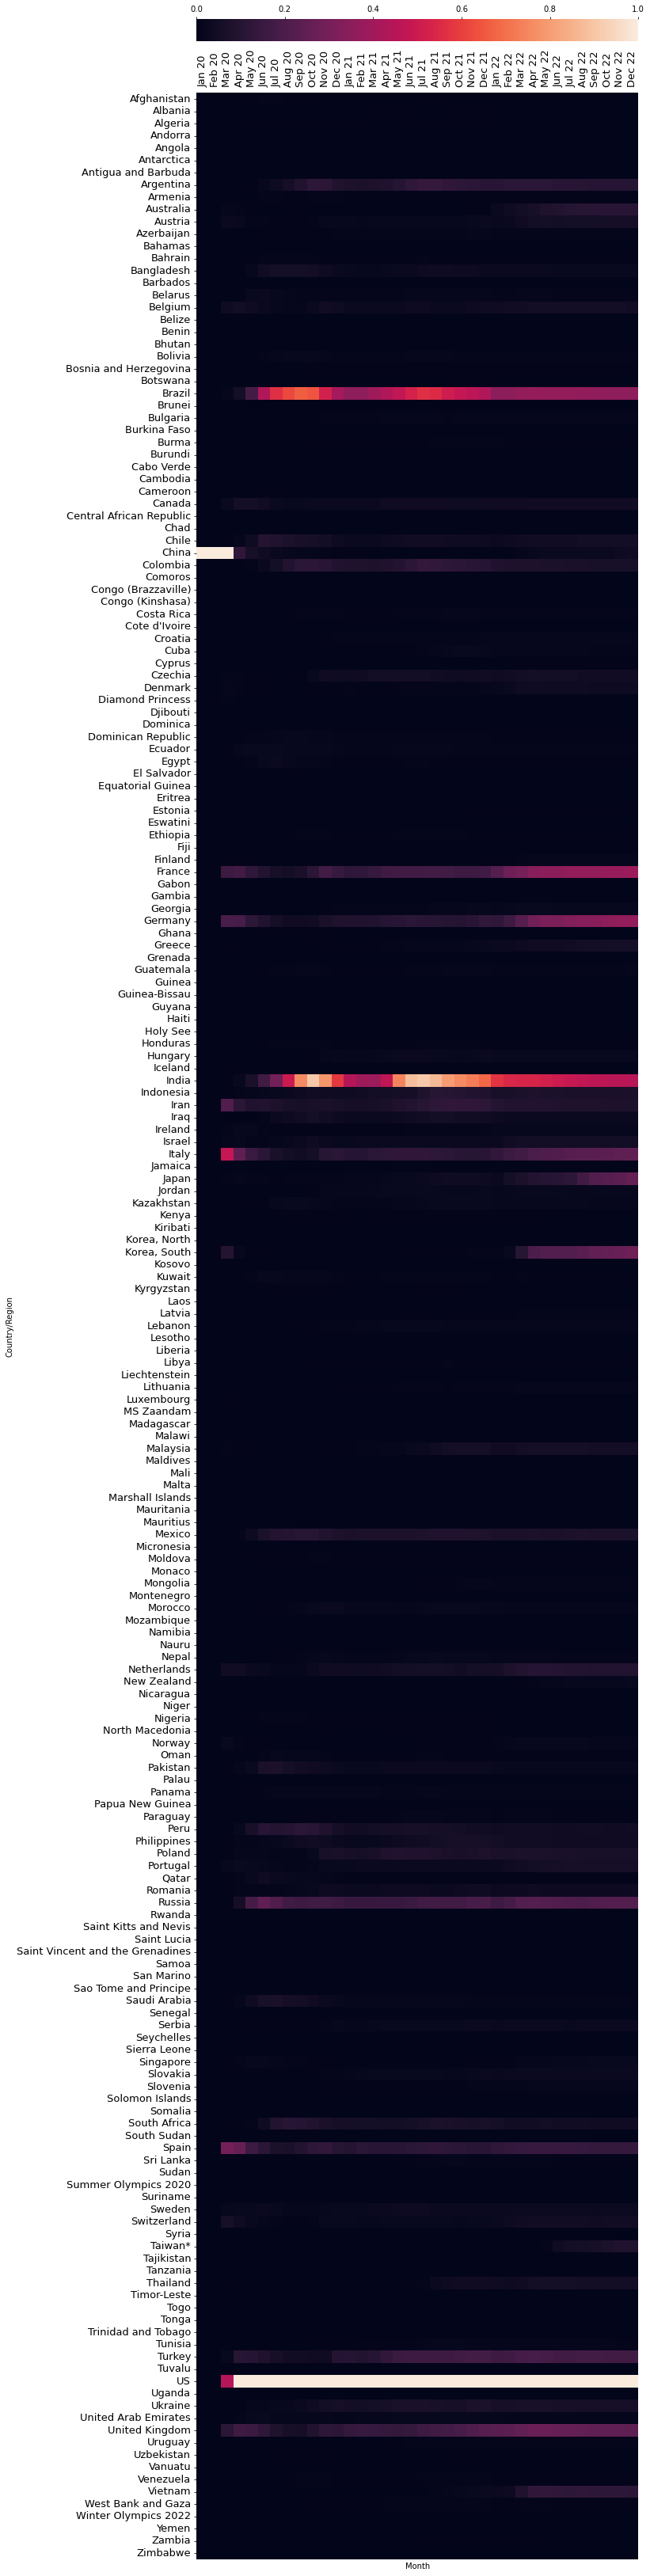

In [8]:
# visualizing month-wise confirmed cases

month_confirmed_T = month_confirmed.transpose()
dates = month_confirmed.index.strftime("%b %y") # changing format of date for labels
countries = month_confirmed_T.index

# normalizing data
month_confirmed_T = preprocessing.MinMaxScaler().fit_transform(month_confirmed_T)
month_confirmed_T = pd.DataFrame(month_confirmed_T, columns=dates, index=countries)

# plotting heatmap
plt.figure(figsize=(10,120))
plt.tick_params(axis='both', which='major', 
                labelsize=13, labelbottom = False, bottom=False, top = False, labeltop=True)
sns.heatmap(data = month_confirmed_T, square=True,
            cbar_kws=dict(use_gridspec=False,location="top",pad=0.01))

# saving heatmap as png
plt.savefig(r'.\results\MonthWise.png',bbox_inches='tight', dpi=300)

In [11]:
# saving results to excel file

with pd.ExcelWriter(r'.\results\Calculations.xlsx', datetime_format='mmm yy') as writer:
    result.to_excel(writer, sheet_name='Results - Q1 & Q2')
    month_confirmed.to_excel(writer, sheet_name='Month-Wise - Q4')